In [ ]:
import sys
import os
from src.utils import (
    Config,
    EEG,
    plt,
    np,
    tqdm, 
    logger
)
from src.train import train, run
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import sklearn.pipeline
import sklearn.model_selection
from datetime import datetime
import logging
import warnings
from tqdm import tqdm
tqdm.pandas()
import mne
from matplotlib import pyplot as plt
from scipy.io import loadmat
import numpy as np
from typing import Tuple, Union
from pathlib import Path
import sklearn

warnings.filterwarnings("ignore")
mne.set_log_level("WARNING")

%matplotlib inline


In [4]:
def plot(mean_scores, fname, text=None):
  fig, ax = plt.subplots(figsize=(12,8))
  
  for i, acc in enumerate(scores):
      ax.plot(times[: len(acc)], acc, label=f"fold: {i+1}", alpha=0.3, linewidth=1)
  
  ax.plot(times[: len(mean_scores)], mean_scores, label="Mean accuracy")
  ax.axhline(0.5, color="k", linestyle="--", label="chance")
  ax.set_xlabel("Time (s)")
  ax.set_ylabel("Accuracy")
  ax.legend()
  ax.axvline(0.0, color="k", linestyle="-")
  title = f"Decoding model performance of sample {fname}"
  if text:
    title += " | N=" + text
  ax.set_title(title)
  ax.grid(True)
  plt.show(block=False)
  plt.pause(0.1)

def multi_plot(all_scores, times, performance):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    axes = axes.flatten()
    
    for idx, (scores, N) in enumerate(zip(all_scores, performance)):
        scores_ = list(scores.values())[0]
        fname = str(list(scores.keys())[0])
        ax = axes[idx]
        
        for i, acc in enumerate(scores_):
            ax.plot(times[:len(acc)], acc, label=f"fold: {i+1}", alpha=0.3, linewidth=1)
        mean_scores = np.mean(scores_, axis=0)
        title = f"Decoding model performance of sample {fname} | N={N}"
      
        ax.plot(times[:len(mean_scores)], mean_scores, label="Mean accuracy", linewidth=2)
        ax.axhline(0.5, color="k", linestyle="--", label="chance")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Accuracy")
        ax.legend(loc='best')
        ax.axvline(0.0, color="k", linestyle="-")
        ax.set_title(title)
        ax.grid(True)

    plt.tight_layout()
    plt.show()
  

In [5]:
# SETTING UP CLASSES INSTANCIATION
config = Config()
eeg = EEG(n_channels=Config().N_CHANNELS, sfreq=Config().S_FREQ)

# DATA READING
# ROOT_DIR = "/home/elbramos/Desktop/IAAA/S2/TER/ter_project/"
# CLEAN_SUBJECTS_PATH = Path(os.path.join(ROOT_DIR, 'data/clean/train'))


NameError: name 'Config' is not defined

In [86]:
data_list = eeg.get_data(
    type="clean", path=CLEAN_DATA_PATH, ext="mat"
)
sample = data_list[0]

config.TIMES = sample["t"].flatten()
fnames = np.array([data["fname"] for data in data_list])

# MODEL BUILDING
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

scaler = StandardScaler()
clf = LogisticRegression(solver="liblinear", max_iter=1000)

pipeline = sklearn.pipeline.Pipeline([("scaler", scaler), ("clf", clf)])


EEG data reading...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]
2025-05-28 15:59:46,533 - INFO - 
Total successfully readed files : 1
2025-05-28 15:59:46,562 - INFO - Sample S03 -> Data shape: (2404, 128, 300)
2025-05-28 15:59:47,362 - INFO - Sample S03 -> Total recording time: 2884.8 sec (48.08 min)


# Utilisation de toutes les données filtrées sans rejet de sourdine et fussy

In [25]:
# DATA LABELIZATION
data_list_labeled = eeg.encode_labels(data_list)


Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.74it/s]


In [26]:
times = sample["t"].flatten()

all_scores = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=data_list_labeled,
        times=config.TIMES,
        average=False,
        N=2,
        reuse=False,
        verbose=False,
    )


2025-05-28 00:35:11,296 - INFO - Selected sample: S03                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 00:35:11,296 - INFO - X shape: (2404, 128, 300) | y shape: (2404,)
2025-05-28 00:35:11,297 - INFO - Phonem: 'ba' | label: 0 | Num: 1208
2025-05-28 00:35:11,299 - INFO - Phonem: 'da' | label: 1 | Num: 1196

2025-05-28 00:35:11,303 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 00:36:06,187 - INFO - Fold: 1, Mean accuracy: 0.486

2025-05-28 00:36:06,191 - INFO - Running Fold 2.█▏                                                                                                                | 1/5 [00:54<03:39, 54.88s/it]
2025-05-28 00:37:00,291 - INFO - Fold: 2, Mean accuracy: 0.498

2025-05-28 00:37:00,296 - INFO - Running Fold 3.█████████████████████████

2025-05-28 00:39:47,844 - INFO - Best accuracy: 0.527


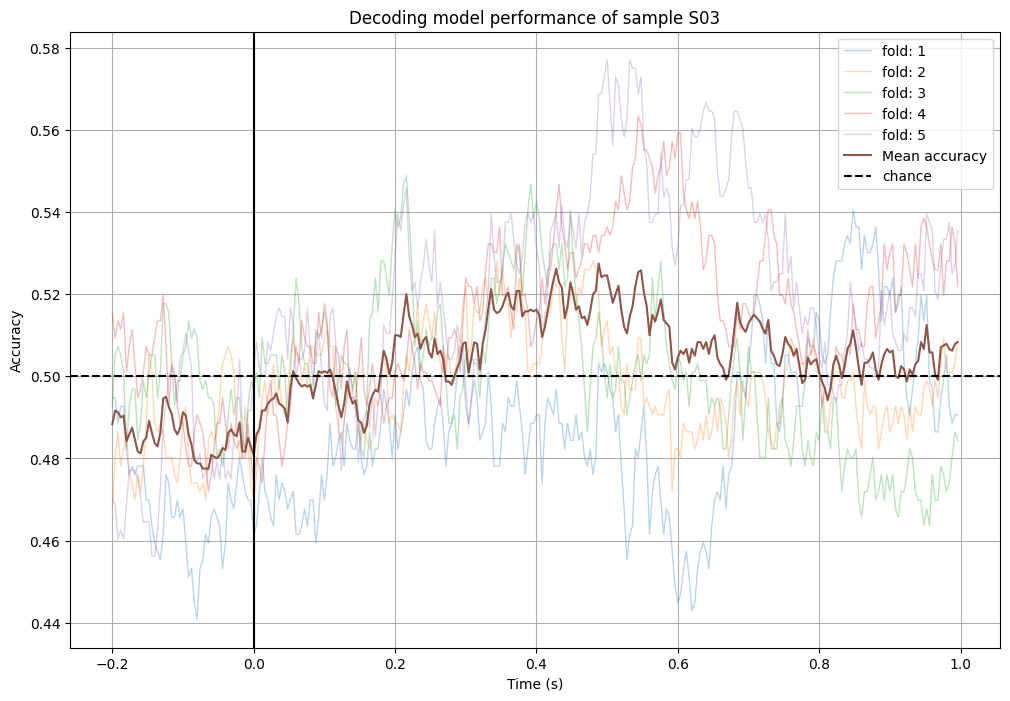

In [27]:
scores = list(all_scores.values())[0]
fname = str(list(all_scores.keys())[0])
mean_scores = np.mean(scores, axis=0)
best_acc = np.max(mean_scores)
logger.info(f"Best accuracy: {best_acc:.3f}")
plot(mean_scores, fname)


# Utilisation de tous les  essais avec rejet des sourdine et fussy

In [28]:
include = [1, 8]
reduced_data_list = eeg.drop_trials(
    data_list.copy(),
    drop_trials=False,
    include=include,
    drop_sourdine=True,
    drop_fussy=True,
)

# DATA LABELIZATION
data_list_labeled = eeg.encode_labels(reduced_data_list)
times = sample["t"].flatten()

all_scores = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=data_list_labeled,
        times=config.TIMES,
        average=False,
        N=None,
        reuse=False,
        verbose=False,
    )


Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 703.39it/s]
2025-05-28 00:39:48,841 - INFO - Selected sample: S03                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 00:39:48,842 - INFO - X shape: (1469, 128, 300) | y shape: (1469,)
2025-05-28 00:39:48,843 - INFO - Phonem: 'ba' | label: 0 | Num: 738
2025-05-28 00:39:48,844 - INFO - Phonem: 'da' | label: 1 | Num: 731

2025-05-28 00:39:48,851 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 00:40:15,869 - INFO - Fold: 1, Mean accuracy: 0.501

2025-05-28 00:40:15,874 - INFO - Running Fold 2.█▏                                                                                           

2025-05-28 00:42:00,989 - INFO - Best accuracy: 0.563


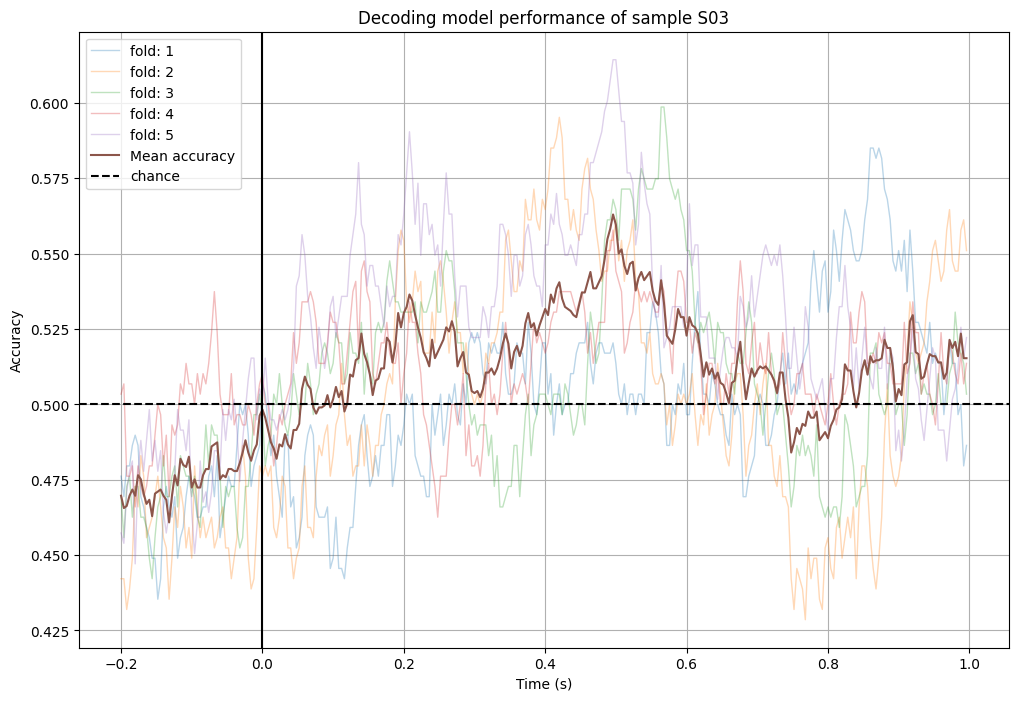

In [29]:
scores = list(all_scores.values())[0]
fname = str(list(all_scores.keys())[0])
mean_scores = np.mean(scores, axis=0)
best_acc = np.max(mean_scores)
logger.info(f"Best accuracy: {best_acc:.3f}")
plot(mean_scores, fname)


# Utilisation de deux essais d'extrémités (1) et (8) avec rejet des sourdine et fussy

In [30]:
include = [1, 8]
reduced_data_list = eeg.drop_trials(
    data_list.copy(),
    drop_trials=True,
    include=include,
    drop_sourdine=True,
    drop_fussy=True,
)

# DATA LABELIZATION
data_list_labeled = eeg.encode_labels(reduced_data_list)

times = sample["t"].flatten()
all_scores = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=data_list_labeled,
        times=config.TIMES,
        average=False,
        N=None,
        reuse=False,
        verbose=False,
    )

Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 686.47it/s]
2025-05-28 00:42:01,677 - INFO - Selected sample: S03                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 00:42:01,682 - INFO - X shape: (366, 128, 300) | y shape: (366,)
2025-05-28 00:42:01,684 - INFO - Phonem: 'ba' | label: 0 | Num: 182
2025-05-28 00:42:01,686 - INFO - Phonem: 'da' | label: 1 | Num: 184

2025-05-28 00:42:01,692 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 00:42:06,652 - INFO - Fold: 1, Mean accuracy: 0.506

2025-05-28 00:42:06,657 - INFO - Running Fold 2.█▏                                                                                             

2025-05-28 00:42:26,750 - INFO - Best accuracy: 0.590


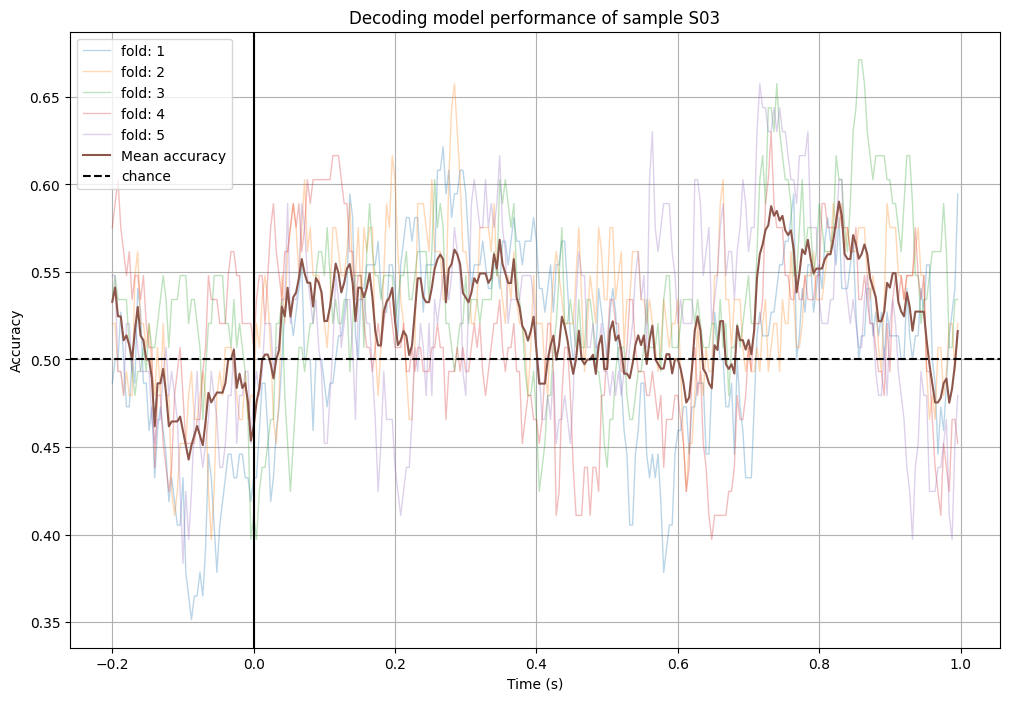

In [31]:
scores = list(all_scores.values())[0]
fname = str(list(all_scores.keys())[0])
mean_scores = np.mean(scores, axis=0)
best_acc = np.max(mean_scores)
logger.info(f"Best accuracy: {best_acc:.3f}")
plot(mean_scores, fname)


# Utilisation des quatres essais d'extrémités (1,2) et (7,8)

In [32]:
include = [1,2, 7,8]
reduced_data_list = eeg.drop_trials(
    data_list.copy(),
    drop_trials=True,
    include=include,
    drop_sourdine=True,
    drop_fussy=True,
)

# DATA LABELIZATION
data_list_labeled = eeg.encode_labels(reduced_data_list)

# DATA PREPARATION FOR TRAIN
times = sample["t"].flatten()
all_scores = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=data_list_labeled,
        times=config.TIMES,
        average=False,
        N=None,
        reuse=False,
        verbose=False,
    )


Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 517.69it/s]
2025-05-28 00:42:27,522 - INFO - Selected sample: S03                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 00:42:27,523 - INFO - X shape: (731, 128, 300) | y shape: (731,)
2025-05-28 00:42:27,525 - INFO - Phonem: 'ba' | label: 0 | Num: 368
2025-05-28 00:42:27,526 - INFO - Phonem: 'da' | label: 1 | Num: 363

2025-05-28 00:42:27,531 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 00:42:37,536 - INFO - Fold: 1, Mean accuracy: 0.543

2025-05-28 00:42:37,540 - INFO - Running Fold 2.█▏                                                                                             

2025-05-28 00:43:17,788 - INFO - Best accuracy: 0.568


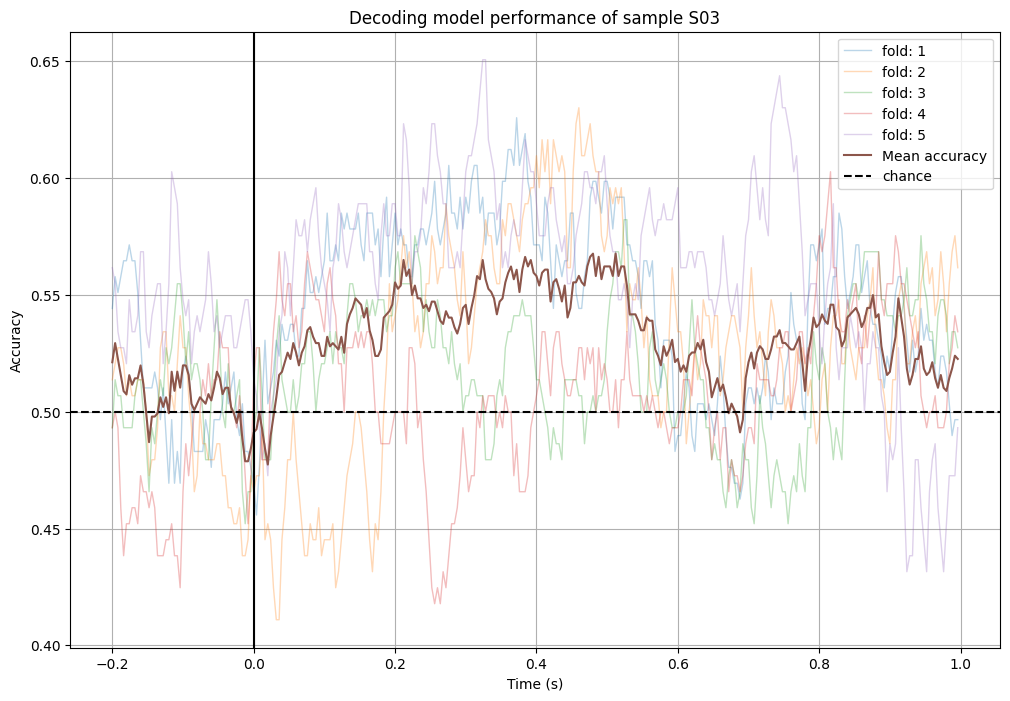

In [33]:
scores = list(all_scores.values())[0]
fname = str(list(all_scores.keys())[0])
mean_scores = np.mean(scores, axis=0)
best_acc = np.max(mean_scores)
logger.info(f"Best accuracy: {best_acc:.3f}")
plot(mean_scores, fname)


# Utilisation de toutes les données non filtrées

In [34]:
# DATA READING
RAW_DATA_PATH = Path(os.path.join(ROOT_DIR, 'data/raw'))

raw_data_list = eeg.get_data(type='raw', path=RAW_DATA_PATH, ext='mat')

raw_sample = raw_data_list[0]
times = raw_sample['t'].flatten()

# DATA LABELIZATION
raw_data_list_labeled = eeg.encode_labels(raw_data_list)

EEG data reading...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.65s/it]
2025-05-28 00:43:21,933 - INFO - 
Total successfully readed files : 1
2025-05-28 00:43:21,964 - INFO - Sample S18 -> Data shape: (2471, 128, 300)
2025-05-28 00:43:22,038 - INFO - Sample S18 -> Total recording time: 2965.2 sec (49.42 min)
Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 415.11it/s]


In [35]:
all_scores = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=raw_data_list_labeled,
        times=config.TIMES,
        average=False,
        N=2,
        reuse=False,
        verbose=False,
    )

2025-05-28 00:43:22,688 - INFO - Selected sample: S18                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 00:43:22,689 - INFO - X shape: (2471, 128, 300) | y shape: (2471,)
2025-05-28 00:43:22,690 - INFO - Phonem: 'ba' | label: 0 | Num: 1235
2025-05-28 00:43:22,691 - INFO - Phonem: 'da' | label: 1 | Num: 1236

2025-05-28 00:43:22,696 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 00:44:27,679 - INFO - Fold: 1, Mean accuracy: 0.503

2025-05-28 00:44:27,685 - INFO - Running Fold 2.█▏                                                                                                                | 1/5 [01:04<04:19, 64.98s/it]
2025-05-28 00:45:55,890 - INFO - Fold: 2, Mean accuracy: 0.494

2025-05-28 00:45:55,916 - INFO - Running Fold 3.█████████████████████████

2025-05-28 00:50:46,946 - INFO - Best accuracy: 0.520


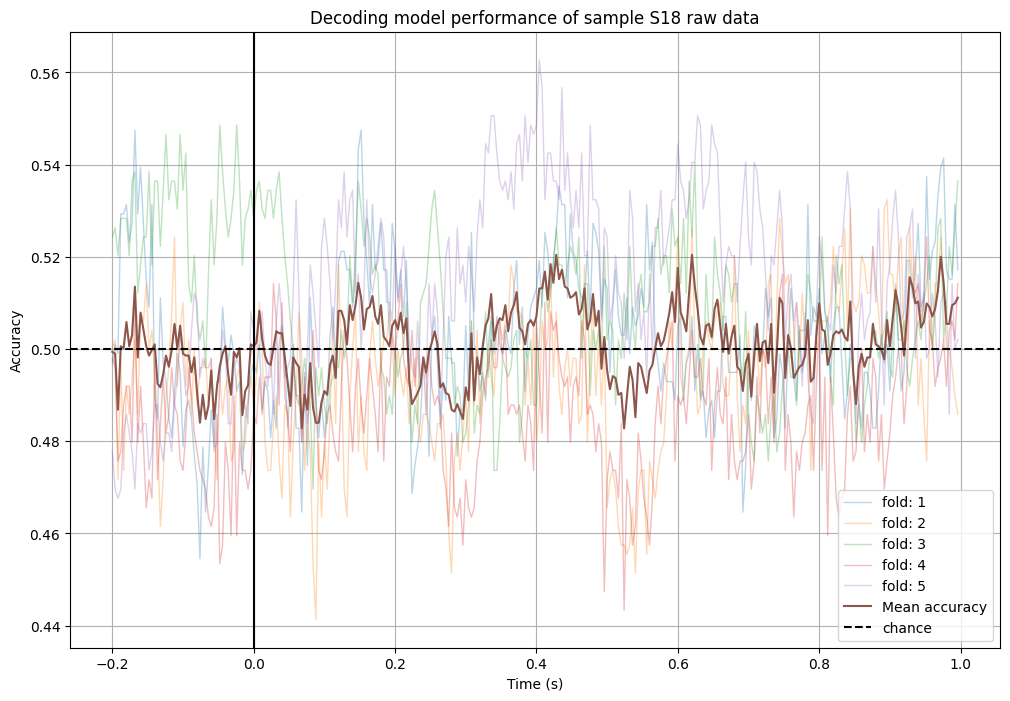

In [36]:
scores = list(all_scores.values())[0]
fname = str(list(all_scores.keys())[0])
fname += " raw data"
mean_scores = np.mean(scores, axis=0)
best_acc = np.max(mean_scores)
logger.info(f"Best accuracy: {best_acc:.3f}")
plot(mean_scores, fname)


# Micro moyenne sans remise

In [37]:
all_scores = []
performance = dict()
# DATA PROCESSING
for N in range(2,11):
  include = [1, 2, 7, 8]
  reduced_data_list = eeg.drop_trials(
      data_list.copy(),
      drop_trials=False,
      include=include,
      drop_sourdine=True,
      drop_fussy=True,
    )
  
  data_list_labeled = eeg.encode_labels(reduced_data_list)

  scores_dict = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=data_list_labeled,
        times=config.TIMES,
        average=True,
        N=N,
        reuse=False,
        verbose=False,
    )
  scores = list(scores_dict.values())[0]
  fname = str(list(scores_dict.keys())[0])
  best_acc = np.max(np.mean(scores, axis=0))
  logger.info(f"N={N} -> Best accuracy: {best_acc:.3f}")
  performance[N] = best_acc
  all_scores.append(scores_dict) 


Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 402.22it/s]
2025-05-28 00:50:48,272 - INFO - Selected sample: S03                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 00:50:48,273 - INFO - X shape: (1469, 128, 300) | y shape: (1469,)
2025-05-28 00:50:48,276 - INFO - Phonem: 'ba' | label: 0 | Num: 738
2025-05-28 00:50:48,277 - INFO - Phonem: 'da' | label: 1 | Num: 731

2025-05-28 00:50:48,285 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 00:50:48,448 - INFO - Applying micro-average of 2.
2025-05-28 00:50:49,339 - INFO - Applying micro-average of 2.
2025-05-28 00:51:02,955 - INFO - Fold: 1, Mean accuracy: 0.510

2025-05-28 00:51:

2025-05-28 00:55:32,540 - INFO - Avg: 2 -> Acc.: 0.5725670498084291
2025-05-28 00:55:32,544 - INFO - Avg: 3 -> Acc.: 0.6111184210526316
2025-05-28 00:55:32,546 - INFO - Avg: 4 -> Acc.: 0.6155454951933825
2025-05-28 00:55:32,548 - INFO - Avg: 5 -> Acc.: 0.5785714285714286
2025-05-28 00:55:32,549 - INFO - Avg: 6 -> Acc.: 0.6256652790625964
2025-05-28 00:55:32,551 - INFO - Avg: 7 -> Acc.: 0.6371794871794872
2025-05-28 00:55:32,553 - INFO - Avg: 8 -> Acc.: 0.5905303030303031
2025-05-28 00:55:32,554 - INFO - Avg: 9 -> Acc.: 0.6383810715609937
2025-05-28 00:55:32,556 - INFO - Avg: 10 -> Acc.: 0.6279999999999999


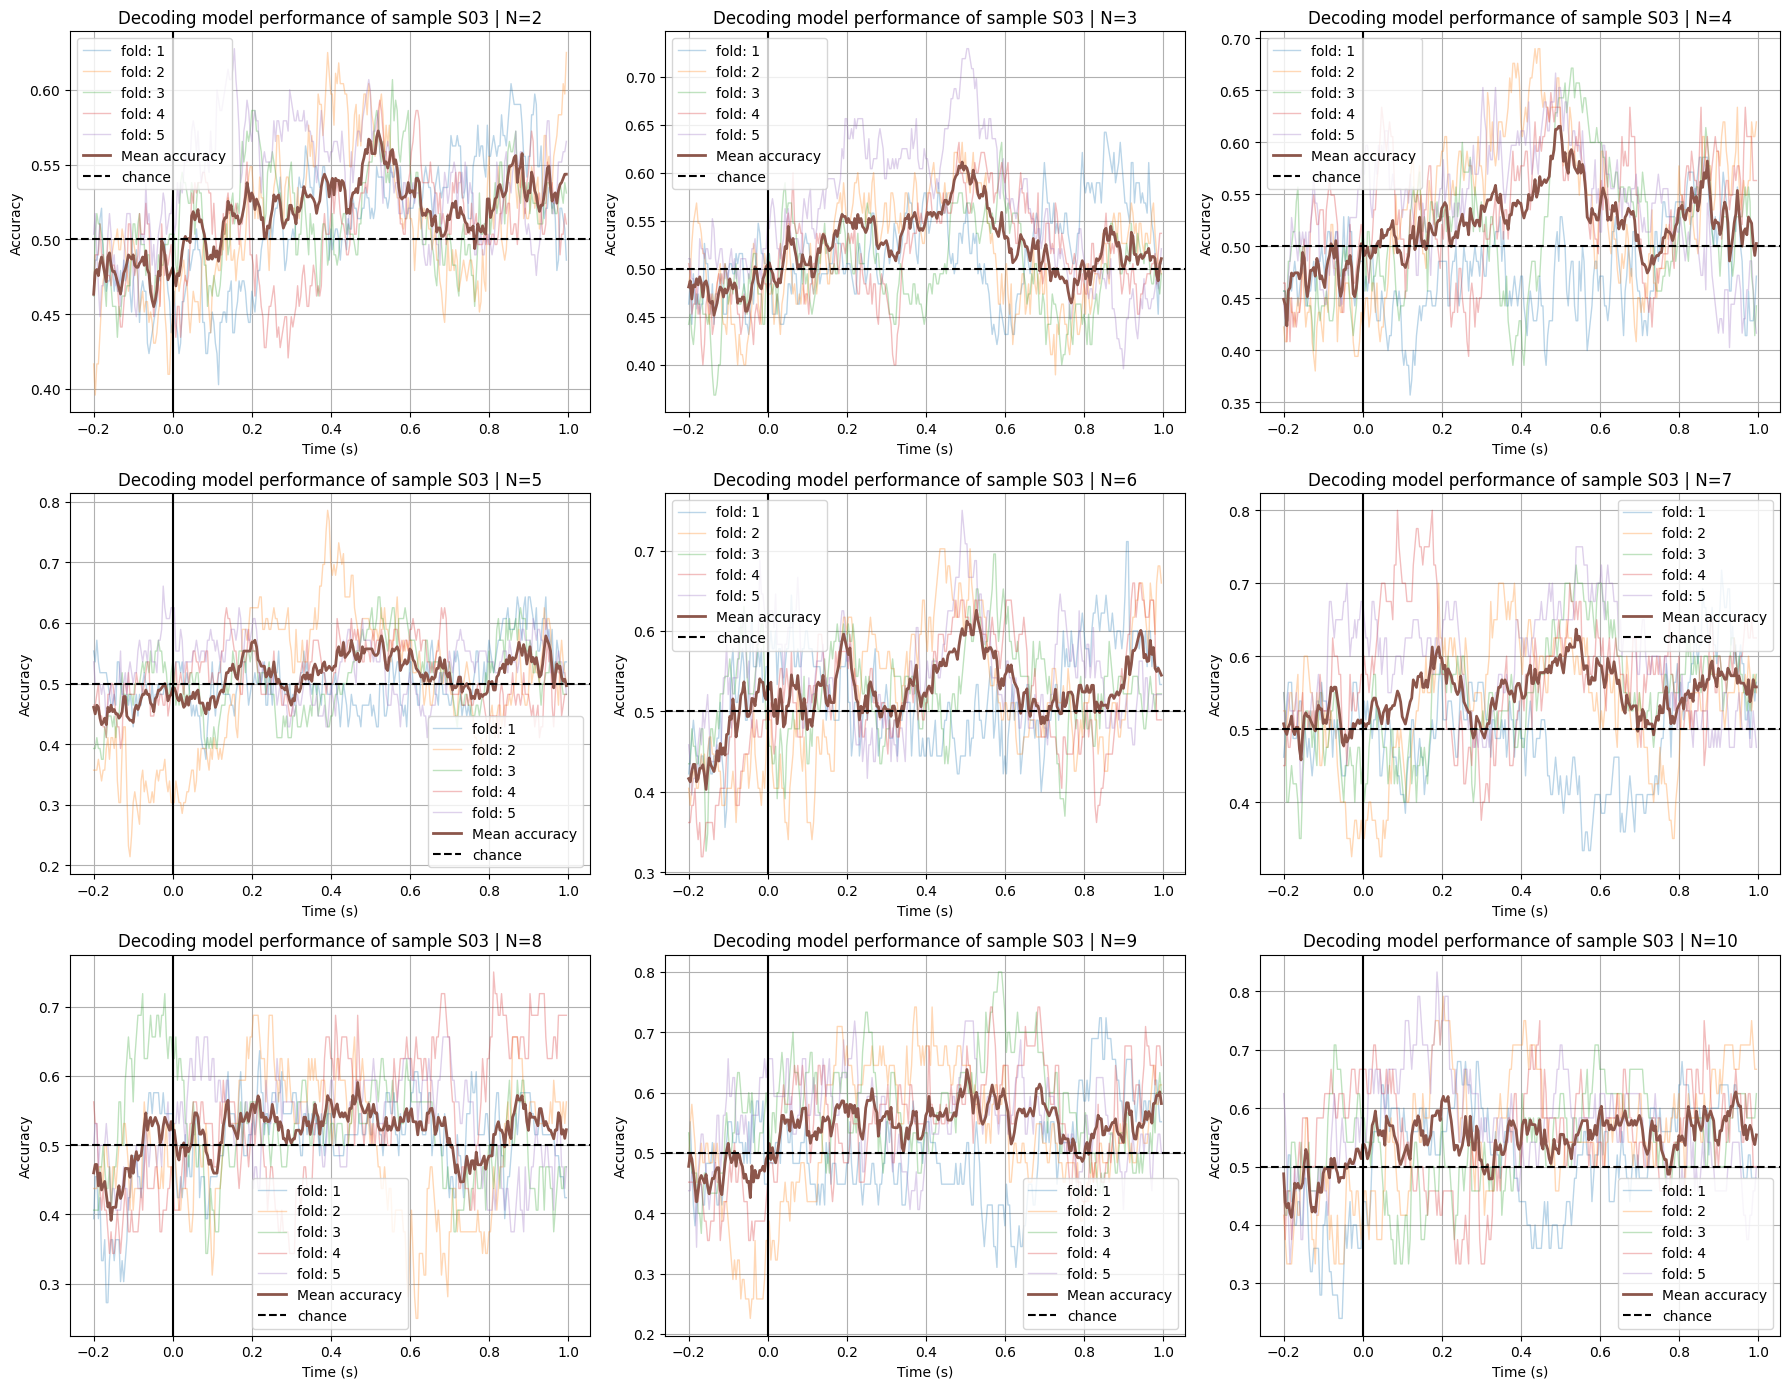

In [38]:
for n, acc in performance.items():
  logger.info(f"Avg: {n} -> Acc.: {acc}")
multi_plot(all_scores, times, performance)


# Micro moyenne avec remise

In [125]:
all_scores = []
performance = dict()
# DATA PROCESSING
for N in range(2,11):
  include = [1, 2, 7, 8]
  reduced_data_list = eeg.drop_trials(
      data_list.copy(),
      drop_trials=False,
      include=include,
      drop_sourdine=True,
      drop_fussy=True,
    )
  data_list_labeled = eeg.encode_labels(reduced_data_list)

  scores_dict = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=data_list_labeled,
        times=config.TIMES,
        average=True,
        N=N,
        reuse=True,
        factor = 0.25,
        verbose=False,
    )
  scores = list(scores_dict.values())[0]
  fname = str(list(scores_dict.keys())[0])
  best_acc = np.max(np.mean(scores, axis=0))
  logger.info(f"N={N} -> Best accuracy: {best_acc:.3f}")
  performance[N] = best_acc
  all_scores.append(scores_dict) 


Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 678.91it/s]
2025-05-28 16:30:31,070 - INFO - Selected sample: S03                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 16:30:31,071 - INFO - X shape: (1469, 128, 300) | y shape: (1469,)
2025-05-28 16:30:31,072 - INFO - Phonem: 'ba' | label: 0 | Num: 738
2025-05-28 16:30:31,073 - INFO - Phonem: 'da' | label: 1 | Num: 731

2025-05-28 16:30:31,078 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 16:30:31,232 - INFO - Applying micro-average of 2.
2025-05-28 16:30:31,233 - INFO - Shape before micro-average: (1175, 128, 300).
2025-05-28 16:30:32,361 - INFO - Shape after micro-average: (146

KeyboardInterrupt: 

In [ ]:
for n, acc in performance.items():
  logger.info(f"Avg: {n} -> Acc.: {acc}")
multi_plot(all_scores, times, performance)


In [126]:
include = [1,2, 7,8]
reduced_data_list = eeg.drop_trials(
    data_list.copy(),
    drop_trials=False,
    include=include,
    drop_sourdine=True,
    drop_fussy=True,
)

# DATA LABELIZATION
data_list_labeled = eeg.encode_labels(reduced_data_list)

# DATA PREPARATION FOR TRAIN
times = sample["t"].flatten()
all_scores = train(
        pipeline=pipeline,
        kfold=skf,
        data_list=data_list_labeled,
        times=config.TIMES,
        average=True,
        N=2,
        reuse=True,
  factor=0.25,
        verbose=False,
    )

Generating labels...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.75it/s]
2025-05-28 16:37:58,874 - INFO - Selected sample: S03                                                                                                                        | 0/1 [00:00<?, ?it/s]
2025-05-28 16:37:58,875 - INFO - X shape: (1469, 128, 300) | y shape: (1469,)
2025-05-28 16:37:58,876 - INFO - Phonem: 'ba' | label: 0 | Num: 738
2025-05-28 16:37:58,877 - INFO - Phonem: 'da' | label: 1 | Num: 731

2025-05-28 16:37:58,882 - INFO - Running Fold 1.                                                                                                                          | 0/5 [00:00<?, ?it/s]
2025-05-28 16:37:59,253 - INFO - Applying micro-average of 2.
2025-05-28 16:37:59,254 - INFO - Shape before micro-average: (1175, 128, 300).
2025-05-28 16:38:00,833 - INFO - Shape after micro-average: (146

2025-05-28 16:41:29,060 - INFO - Best accuracy: 0.581


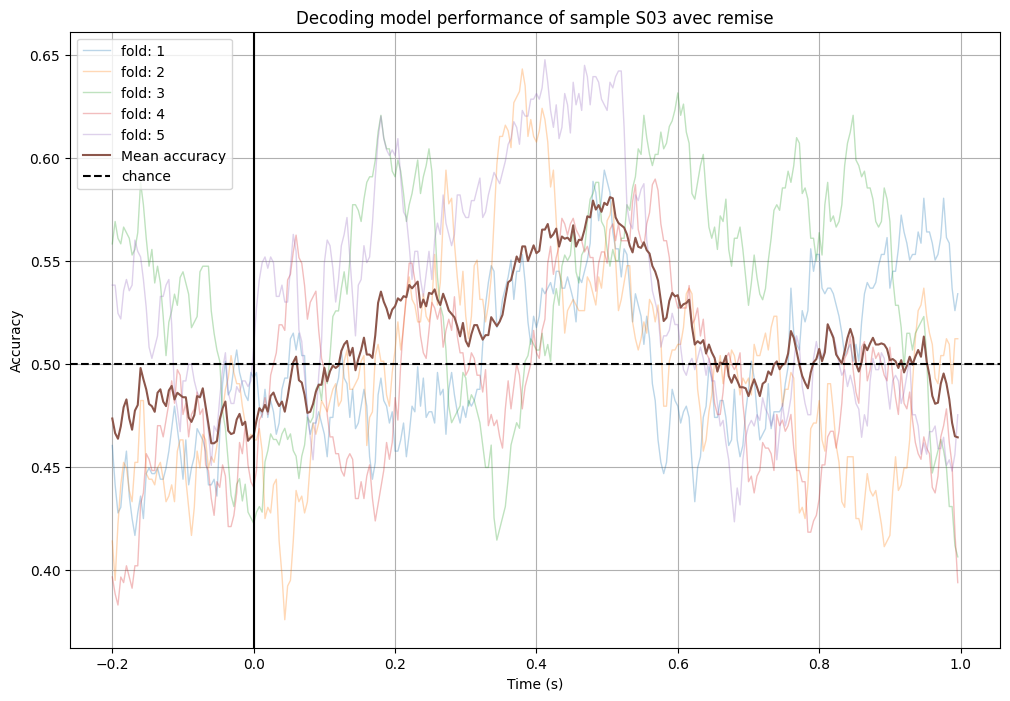

In [127]:
scores = list(all_scores.values())[0]
fname = str(list(all_scores.keys())[0])
fname += " avec remise"
mean_scores = np.mean(scores, axis=0)
best_acc = np.max(mean_scores)
logger.info(f"Best accuracy: {best_acc:.3f}")
plot(mean_scores, fname)
